
**获取数据集信息**


In [2]:
from scipy.io import loadmat

data = loadmat('/Users/lvangge/Desktop/Archive/project1_release/codes/digits.mat')

print(data.keys())

# 获取特定变量的值
for i in data.keys():
    try:
        print(f"{i}_shape:{data[i].shape}")
    except:
        continue

dict_keys(['__header__', '__version__', '__globals__', 'Xtest', 'ytest', 'X', 'y', 'Xvalid', 'yvalid'])
Xtest_shape:(1000, 256)
ytest_shape:(1000, 1)
X_shape:(5000, 256)
y_shape:(5000, 1)
Xvalid_shape:(5000, 256)
yvalid_shape:(5000, 1)



**查看加载其中一张图片**


[[  0  29  85   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 135 208   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  4 212 224   0   0   0   0   0   0   0   0   0   0  45   4   0]
 [  8 241 158   0   0   0   0  33  98   0   0   0  75 249 146   3]
 [108 255 142   0   0   0  14 248 255  70   0   8 148 249 255  24]
 [173 255 142   0   0   0 138 255 250  42   0  42 104  95 255  90]
 [173 255  93   0   0 103 247 255 113   0   0   0   0  63 255 139]
 [173 255  61   0 140 249 255 255  80   0   0   0   0  13 241 171]
 [173 255  61 107 255 255 255 255  97   0   0   0  11 167 255 106]
 [140 255 151 245 255 197 214 255 162   0   0   0 151 255 225   5]
 [ 92 255 255 255 207  12 137 255 162   0   0 108 255 255  83   0]
 [ 92 255 255 238  40   0  72 255 162   0  59 245 255 171   4   0]
 [  8 241 249  73   0   0  29 250 214  61 199 255 207  12   0   0]
 [  0  77  68   0   0   0   0 213 255 255 255 255  88   0   0   0]
 [  0   0   0   0   0   0   0  98 255 255 248 137   0   0   0 

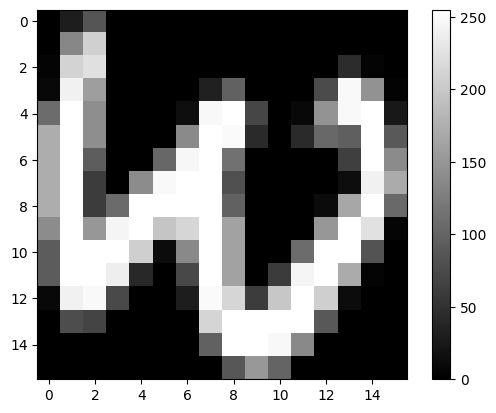

The index of the image:[3]


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 创建一个二维数据（假设是灰度值）
data = loadmat('/Users/lvangge/Desktop/Archive/project1_release/codes/digits.mat')
data_plot = data['X'][666].reshape(16,16)
data_plot_index = data['y'][0]

print(data_plot)
plt.imshow(data_plot, cmap='gray', vmin=0, vmax=255)  # 设置颜色映射的范围
plt.colorbar()  # 添加颜色条
plt.show()
print(f"The index of the image:{data_plot_index}")



**基于给定的初始代码，运行得到错误率**



In [4]:
import numpy as np
from scipy.io import loadmat

# Load data
data = loadmat('/Users/lvangge/Desktop/Archive/project1_release/codes/digits.mat')
X = data['X']
y = data['y']
nLabels = max(y)[0]
Xvalid = data['Xvalid']
Xtest = data['Xtest']
yvalid = data['yvalid']
ytest = data['ytest']

# Function to expand y to binary matrix
def linearInd2Binary(ind, nLabels):
    n = len(ind)
    y = -np.ones((n, nLabels))
    for i in range(n):
        y[i, int(ind[i])-1] = 1
    return y

yExpanded = linearInd2Binary(y,nLabels)

def sech(x):
    return 2 / (np.exp(x) + np.exp(-x))

# Standardize columns and add bias
def standardize_cols(M, mu=None, sigma2=None):
    M = M.astype(float)  # transform the matrix to float type
    nrows, ncols = M.shape

    if mu is None or sigma2 is None:
        mu = np.mean(M, axis=0)
        sigma2 = np.std(M, axis=0)
        # handle the situation that sigma == 0
        sigma2[sigma2 < np.finfo(float).eps] = 1

    S = M - mu
    if ncols > 0:
        S = S / sigma2

    return S, mu, sigma2

def MLP_classification_loss(w, X, y, nHidden, nLabels):
    nInstances, nVars = X.shape # the number of cases and character

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + nHidden[h-2] * nHidden[h-1]], (nHidden[h-2], nHidden[h-1])))
        offset += nHidden[h-2] * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + nHidden[-1] * nLabels], (nHidden[-1], nLabels))

    #Loss function and gradient
    f = 0
    gInput = np.zeros_like(inputWeights)
    gHidden = [np.zeros_like(hidden) for hidden in hiddenWeights]
    gOutput = np.zeros_like(outputWeights)

    # Compute Output
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])] # use tanh as activation function
        for h in range(1, len(nHidden)):
            ip.append(np.dot(fp[h-1], hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        yhat = np.dot(fp[-1], outputWeights)

        relativeErr = yhat - y[i]
        f += np.sum(relativeErr ** 2) # use squared error

        if gInput is not None:
            err = 2 * relativeErr

            # Output Weights
            for c in range(nLabels):
                gOutput[:, c] += err[c] * fp[-1]

            if len(nHidden) > 1:
                # Last Layer of Hidden Weights
                backprop = np.zeros_like(hiddenWeights[-1])
                for c in range(nLabels):
                    backprop[c, :] = err[c] * (np.sech(ip[-1]) ** 2) * outputWeights[:, c]
                    gHidden[-1] += np.outer(fp[-2], backprop[c, :])
                backprop = np.sum(backprop, axis=0)

                # Other Hidden Layers
                for h in range(len(nHidden) - 2, 0, -1):
                    backprop = np.dot(backprop, hiddenWeights[h].T) * (sech(ip[h]) ** 2)
                    gHidden[h-1] += np.outer(fp[h-1], backprop)

                # Input Weights
                backprop = np.dot(backprop, hiddenWeights[0].T) * (sech(ip[0]) ** 2)
                gInput += np.outer(X[i], backprop)
            else:
                # Input Weights
                for c in range(nLabels):
                    gInput += err[c] * np.outer(X[i], (sech(ip[-1]) ** 2) * outputWeights[:, c])

    # Put Gradient into vector
    g = np.concatenate([gInput.flatten(), *[grad.flatten() for grad in gHidden], gOutput.flatten()])

    return f, g

def MLP_classification_predict(w, X, nHidden, nLabels):
    nInstances, nVars = X.shape

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + nHidden[h-2] * nHidden[h-1]], (nHidden[h-2], nHidden[h-1])))
        offset += nHidden[h-2] * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + nHidden[-1] * nLabels], (nHidden[-1], nLabels))

    # Compute Output
    y = np.zeros((nInstances, nLabels))
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])]
        for h in range(1, len(nHidden)):
            ip.append(np.dot(fp[h-1], hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        y[i] = np.dot(fp[-1], outputWeights)

    y = np.argmax(y, axis=1) + 1

    return y


X, mu, sigma = standardize_cols(X)
X = np.hstack((np.ones((X.shape[0], 1)), X)) # add bias column

Xvalid = standardize_cols(Xvalid, mu, sigma)[0]
Xvalid = np.hstack((np.ones((Xvalid.shape[0], 1)), Xvalid))

Xtest = standardize_cols(Xtest, mu, sigma)[0]
Xtest = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))

# Choose network structure
nHidden = [10]

# Initialize weights 'w'
nParams = X.shape[1] * nHidden[0]
for h in range(1, len(nHidden)):
    nParams += nHidden[h-1] * nHidden[h]
nParams += nHidden[-1] * np.max(y)
w = np.random.randn(nParams)

# Train with stochastic gradient descent
maxIter = 10000
stepSize = 1e-3
for iter in range(1, maxIter+1):
    if (iter-1) % round(maxIter/20) == 0:
        yhat = MLP_classification_predict(w, Xvalid, nHidden, np.max(y))
        print(f'Training iteration = {iter-1}, validation error = {np.sum(yhat != yvalid.reshape(Xvalid.shape[0]))/Xvalid.shape[0]:.2%}')
    
    i = np.random.randint(0, len(X))
    X_i = X[i].reshape(1, -1)
    yExpanded_i = yExpanded[i].reshape(1, -1)
    f, g = MLP_classification_loss(w, X_i, yExpanded_i, nHidden, np.max(y))
    w = w - stepSize * g

# Evaluate test error
yhat = MLP_classification_predict(w, Xtest, nHidden, np.max(y))
print(f'Test error with final model = {np.sum([yhat[i]!=ytest[i] for i in range(len(ytest))])/len(ytest):.2%}')


Training iteration = 0, validation error = 85.24%
Training iteration = 500, validation error = 81.06%
Training iteration = 1000, validation error = 77.94%
Training iteration = 1500, validation error = 74.82%
Training iteration = 2000, validation error = 67.78%
Training iteration = 2500, validation error = 64.46%
Training iteration = 3000, validation error = 63.16%
Training iteration = 3500, validation error = 62.92%
Training iteration = 4000, validation error = 59.22%
Training iteration = 4500, validation error = 57.28%
Training iteration = 5000, validation error = 59.18%
Training iteration = 5500, validation error = 59.50%
Training iteration = 6000, validation error = 60.18%
Training iteration = 6500, validation error = 58.02%
Training iteration = 7000, validation error = 58.52%
Training iteration = 7500, validation error = 58.48%
Training iteration = 8000, validation error = 57.82%
Training iteration = 8500, validation error = 58.38%
Training iteration = 9000, validation error = 56.6

**<span style="font-size:18pt">尝试修改神经网络层结构</span>**

In [30]:
import numpy as np
from scipy.io import loadmat
import copy

# Load data
data = loadmat('/Users/lvangge/Desktop/Archive/project1_release/codes/digits.mat')
X = data['X']
y = data['y']
nLabels = max(y)[0]
Xvalid = data['Xvalid']
Xtest = data['Xtest']
yvalid = data['yvalid']
ytest = data['ytest']

# Function to expand y to binary matrix
def linearInd2Binary(ind, nLabels):
    n = len(ind)
    y = -np.ones((n, nLabels))
    for i in range(n):
        y[i, int(ind[i])-1] = 1
    return y

yExpanded = linearInd2Binary(y,nLabels)

def sech(x):
    return 2 / (np.exp(x) + np.exp(-x))

# Standardize columns and add bias
def standardize_cols(M, mu=None, sigma2=None):
    M = M.astype(float)  # transform the matrix to float type
    nrows, ncols = M.shape

    if mu is None or sigma2 is None:
        mu = np.mean(M, axis=0)
        sigma2 = np.std(M, axis=0)
        # handle the situation that sigma == 0
        sigma2[sigma2 < np.finfo(float).eps] = 1

    S = M - mu
    if ncols > 0:
        S = S / sigma2

    return S, mu, sigma2

def MLP_classification_loss(w, X, y, nHidden, nLabels, lam=0.5):
    nInstances, nVars = X.shape # the number of cases and character

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + nHidden[h-2] * nHidden[h-1]], (nHidden[h-2], nHidden[h-1])))
        offset += nHidden[h-2] * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + nHidden[-1] * nLabels], (nHidden[-1], nLabels))

    #Loss function and gradient
    f = 0
    gInput = np.zeros_like(inputWeights)
    gHidden = [np.zeros_like(hidden) for hidden in hiddenWeights]
    gOutput = np.zeros_like(outputWeights)

    # Compute Output
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])] # use tanh as activation function
        for h in range(1, len(nHidden)):
            ip.append(np.dot(fp[h-1], hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        yhat = np.dot(fp[-1], outputWeights)

        relativeErr = yhat - y[i]
        f += np.sum(relativeErr ** 2) / (nInstances * nLabels)  # use squared error

        if gInput is not None:
            err = 2 * relativeErr

            # Output Weights
            for c in range(nLabels):
                gOutput[:, c] += err[c] * fp[-1]

            if len(nHidden) > 1:
                # Last Layer of Hidden Weights
                backprop = np.zeros_like(hiddenWeights[-1])
                for c in range(nLabels):
                    backprop[c, :] = err[c] * (sech(ip[-1]) ** 2) * outputWeights[:, c]
                    gHidden[-1] += np.outer(fp[-2], backprop[c, :])
                backprop = np.sum(backprop, axis=0)

                # Other Hidden Layers
                for h in range(len(nHidden) - 2, 0, -1):
                    backprop = np.dot(backprop, hiddenWeights[h].T) * (sech(ip[h]) ** 2)
                    gHidden[h-1] += np.outer(fp[h-1], backprop)

                # Input Weights
                backprop = np.dot(backprop, hiddenWeights[0].T) * (sech(ip[0]) ** 2)
                gInput += np.outer(X[i], backprop)
            else:
                # Input Weights
                for c in range(nLabels):
                    gInput += err[c] * np.outer(X[i], (sech(ip[-1]) ** 2) * outputWeights[:, c])
    # add l2 regulation
    f += 0.5 * lam * (np.sum(inputWeights ** 2) + np.sum(outputWeights ** 2))
    for hidden in hiddenWeights:
        f += 0.5 * lam * np.sum(hidden ** 2)
    
    #l2 term
    gInput += lam * inputWeights
    for h in range(len(nHidden)-1):
        gHidden[h] += lam * hiddenWeights[h]
    gOutput += lam * outputWeights

    # Put Gradient into vector
    g = np.concatenate([gInput.flatten(), *[grad.flatten() for grad in gHidden], gOutput.flatten()])

    return f, g

def MLP_classification_predict(w, X, nHidden, nLabels):
    nInstances, nVars = X.shape

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + nHidden[h-2] * nHidden[h-1]], (nHidden[h-2], nHidden[h-1])))
        offset += nHidden[h-2] * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + nHidden[-1] * nLabels], (nHidden[-1], nLabels))

    # Compute Output
    y = np.zeros((nInstances, nLabels))
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])]
        for h in range(1, len(nHidden)):
            ip.append(np.dot(fp[h-1], hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        y[i] = np.dot(fp[-1], outputWeights)

    y = np.argmax(y, axis=1) + 1

    return y


X, mu, sigma = standardize_cols(X)
X = np.hstack((np.ones((X.shape[0], 1)), X)) # add bias column

Xvalid = standardize_cols(Xvalid, mu, sigma)[0]
Xvalid = np.hstack((np.ones((Xvalid.shape[0], 1)), Xvalid))

Xtest = standardize_cols(Xtest, mu, sigma)[0]
Xtest = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))

# Choose network structure
nHidden = [50]

# Initialize weights 'w'
nParams = X.shape[1] * nHidden[0]
for h in range(1, len(nHidden)):
    nParams += nHidden[h-1] * nHidden[h]
nParams += nHidden[-1] * np.max(y)
w = np.random.randn(nParams)

# Train with stochastic gradient descent
maxIter = 10000
stepSize = 1e-3
momentum = 0.9
w_history = [w]
for iter in range(1, maxIter+1):
    if (iter-1) % round(maxIter/20) == 0:
        yhat = MLP_classification_predict(w, Xvalid, nHidden, np.max(y))
        print(f'Training iteration = {iter-1}, validation error = {np.sum(yhat != yvalid.reshape(Xvalid.shape[0]))/Xvalid.shape[0]:.2%}')
    
    i = np.random.randint(0, len(X))
    X_i = X[i].reshape(1, -1)
    yExpanded_i = yExpanded[i].reshape(1, -1)
    f, g = MLP_classification_loss(w, X_i, yExpanded_i, nHidden, np.max(y))
    w_history.append(w)
    w = w - stepSize * g + momentum * (w - w_history[0])
    w_history.pop(0)
# Evaluate test error
yhat = MLP_classification_predict(w, Xtest, nHidden, np.max(y))
print(f'Test error with final model = {np.sum([yhat[i]!=ytest[i] for i in range(len(ytest))])/len(ytest):.2%}')


Training iteration = 0, validation error = 90.56%
Training iteration = 500, validation error = 42.42%
Training iteration = 1000, validation error = 42.12%
Training iteration = 1500, validation error = 43.10%
Training iteration = 2000, validation error = 45.92%
Training iteration = 2500, validation error = 42.68%
Training iteration = 3000, validation error = 53.02%
Training iteration = 3500, validation error = 45.82%
Training iteration = 4000, validation error = 51.14%
Training iteration = 4500, validation error = 40.16%
Training iteration = 5000, validation error = 38.88%
Training iteration = 5500, validation error = 41.96%
Training iteration = 6000, validation error = 37.50%
Training iteration = 6500, validation error = 41.48%
Training iteration = 7000, validation error = 42.32%
Training iteration = 7500, validation error = 43.06%
Training iteration = 8000, validation error = 47.36%
Training iteration = 8500, validation error = 52.52%
Training iteration = 9000, validation error = 42.0

**<span style="font-size:18pt">修改激活函数为softmax函数,使用交叉熵函数作为损失函数,y的编码为{0,1}的one-hot编码</span>**

In [37]:
import numpy as np
from scipy.io import loadmat
import copy

# Load data
data = loadmat('/Users/lvangge/Desktop/Archive/project1_release/codes/digits.mat')
X = data['X']
y = data['y']
nLabels = max(y)[0]
Xvalid = data['Xvalid']
Xtest = data['Xtest']
yvalid = data['yvalid']
ytest = data['ytest']

# Function to expand y to binary matrix
def linearInd2Binary(ind, nLabels):
    n = len(ind)
    y = np.zeros((n, nLabels))
    for i in range(n):
        y[i, int(ind[i])-1] = 1
    return y

yExpanded = linearInd2Binary(y,nLabels)

def sech(x):
    return 2 / (np.exp(x) + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, keepdims=True))
    return exp_x / np.sum(exp_x, keepdims=True)

# Standardize columns and add bias
def standardize_cols(M, mu=None, sigma2=None):
    M = M.astype(float)  # transform the matrix to float type
    nrows, ncols = M.shape

    if mu is None or sigma2 is None:
        mu = np.mean(M, axis=0)
        sigma2 = np.std(M, axis=0)
        # handle the situation that sigma == 0
        sigma2[sigma2 < np.finfo(float).eps] = 1

    S = M - mu
    if ncols > 0:
        S = S / sigma2

    return S, mu, sigma2

def MLP_classification_loss(w, X, y, nHidden, nLabels):
    nInstances, nVars = X.shape # the number of cases and character

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + nHidden[h-2] * nHidden[h-1]], (nHidden[h-2], nHidden[h-1])))
        offset += nHidden[h-2] * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + nHidden[-1] * nLabels], (nHidden[-1], nLabels))

    #Loss function and gradient
    f = 0
    gInput = np.zeros_like(inputWeights)
    gHidden = [np.zeros_like(hidden) for hidden in hiddenWeights]
    gOutput = np.zeros_like(outputWeights)

    # Compute Output
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])] # use tanh as activation function
        for h in range(1, len(nHidden)):
            ip.append(np.dot(fp[h-1], hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        logits = np.dot(fp[-1], outputWeights)
        probs = softmax(logits)

        f += -np.dot(np.log(probs + 1e-10), y[i])

        if gInput is not None:
            err = probs - y[i]  # Gradient of the softmax output

            # Output Weights
            gOutput += np.outer(fp[-1], err)

            if len(nHidden) > 1:
                # Last Layer of Hidden Weights
                backprop = np.dot(err, outputWeights.T) * (sech(ip[-1]) ** 2)
                gHidden[-1] += np.outer(fp[-2], backprop)

                # Other Hidden Layers
                for h in range(len(nHidden) - 2, 0, -1):
                    backprop = np.dot(backprop, hiddenWeights[h].T) * (sech(ip[h]) ** 2)
                    gHidden[h-1] += np.outer(fp[h-1], backprop)

                # Input Weights
                backprop = np.dot(backprop, hiddenWeights[0].T) * (sech(ip[0]) ** 2)
                gInput += np.outer(X[i], backprop)
            else:
                # Input Weights
                gInput += np.outer(X[i], (sech(ip[-1]) ** 2) * np.dot(err, outputWeights.T))

    # Put Gradient into vector
    g = np.concatenate([gInput.flatten(), *[grad.flatten() for grad in gHidden], gOutput.flatten()])

    return f, g

def MLP_classification_predict(w, X, nHidden, nLabels):
    nInstances, nVars = X.shape

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + nHidden[h-2] * nHidden[h-1]], (nHidden[h-2], nHidden[h-1])))
        offset += nHidden[h-2] * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + nHidden[-1] * nLabels], (nHidden[-1], nLabels))

    # Compute Output
    y = np.zeros((nInstances, nLabels))
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])]
        for h in range(1, len(nHidden)):
            ip.append(np.dot(fp[h-1], hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        y[i] = np.dot(fp[-1], outputWeights)

    y = np.argmax(y, axis=1) + 1

    return y


X, mu, sigma = standardize_cols(X)
X = np.hstack((np.ones((X.shape[0], 1)), X)) # add bias column

Xvalid = standardize_cols(Xvalid, mu, sigma)[0]
Xvalid = np.hstack((np.ones((Xvalid.shape[0], 1)), Xvalid))

Xtest = standardize_cols(Xtest, mu, sigma)[0]
Xtest = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))

# Choose network structure
nHidden = [50]

# Initialize weights 'w'
nParams = X.shape[1] * nHidden[0]
for h in range(1, len(nHidden)):
    nParams += nHidden[h-1] * nHidden[h]
nParams += nHidden[-1] * np.max(y)
w = np.random.randn(nParams)

# Train with stochastic gradient descent
maxIter = 10000
stepSize = 1e-3
momentum = 0.9
w_history = [w]
for iter in range(1, maxIter+1):
    if (iter-1) % round(maxIter/20) == 0:
        yhat = MLP_classification_predict(w, Xvalid, nHidden, np.max(y))
        f = MLP_classification_loss(w, Xvalid, linearInd2Binary(yvalid,nLabels), nHidden, np.max(y))[0]
        print(f'Training iteration = {iter-1},Loss={f:.2f},validation error = {np.sum(yhat != yvalid.reshape(Xvalid.shape[0]))/Xvalid.shape[0]:.2%}')
    
    i = np.random.randint(0, len(X))
    X_i = X[i].reshape(1, -1)
    yExpanded_i = yExpanded[i].reshape(1, -1)
    f, g = MLP_classification_loss(w, X_i, yExpanded_i, nHidden, np.max(y))
    w_history.append(w)
    w = w - stepSize * g + momentum * (w - w_history[0])
    w_history.pop(0)
# Evaluate test error
yhat = MLP_classification_predict(w, Xtest, nHidden, np.max(y))
print(f'Test error with final model = {np.sum([yhat[i]!=ytest[i] for i in range(len(ytest))])/len(ytest):.2%}')


Training iteration = 0,Loss=57018.86,validation error = 92.24%
Training iteration = 500,Loss=27783.98,validation error = 71.28%
Training iteration = 1000,Loss=18285.36,validation error = 58.10%
Training iteration = 1500,Loss=13838.29,validation error = 48.78%
Training iteration = 2000,Loss=11254.02,validation error = 43.20%
Training iteration = 2500,Loss=9819.82,validation error = 40.26%
Training iteration = 3000,Loss=8740.41,validation error = 36.66%
Training iteration = 3500,Loss=8015.45,validation error = 33.86%
Training iteration = 4000,Loss=7507.07,validation error = 31.66%
Training iteration = 4500,Loss=7114.07,validation error = 30.44%
Training iteration = 5000,Loss=6539.74,validation error = 29.40%
Training iteration = 5500,Loss=6218.05,validation error = 28.40%
Training iteration = 6000,Loss=5948.28,validation error = 27.56%
Training iteration = 6500,Loss=5736.81,validation error = 26.94%
Training iteration = 7000,Loss=5430.60,validation error = 26.08%
Training iteration = 750


**<span style="font-size:18pt">加上l2正则化项</span>**


In [39]:
import numpy as np
from scipy.io import loadmat
import copy

# Load data
data = loadmat('/Users/lvangge/Desktop/Archive/project1_release/codes/digits.mat')
X = data['X']
y = data['y']
nLabels = max(y)[0]
Xvalid = data['Xvalid']
Xtest = data['Xtest']
yvalid = data['yvalid']
ytest = data['ytest']

# Function to expand y to binary matrix
def linearInd2Binary(ind, nLabels):
    n = len(ind)
    y = np.zeros((n, nLabels))
    for i in range(n):
        y[i, int(ind[i])-1] = 1
    return y

yExpanded = linearInd2Binary(y,nLabels)

def sech(x):
    return 2 / (np.exp(x) + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, keepdims=True))
    return exp_x / np.sum(exp_x, keepdims=True)

# Standardize columns and add bias
def standardize_cols(M, mu=None, sigma2=None):
    M = M.astype(float)  # transform the matrix to float type
    nrows, ncols = M.shape

    if mu is None or sigma2 is None:
        mu = np.mean(M, axis=0)
        sigma2 = np.std(M, axis=0)
        # handle the situation that sigma == 0
        sigma2[sigma2 < np.finfo(float).eps] = 1

    S = M - mu
    if ncols > 0:
        S = S / sigma2

    return S, mu, sigma2

def MLP_classification_loss(w, X, y, nHidden, nLabels, lam=0.5):
    nInstances, nVars = X.shape # the number of cases and character

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + nHidden[h-2] * nHidden[h-1]], (nHidden[h-2], nHidden[h-1])))
        offset += nHidden[h-2] * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + nHidden[-1] * nLabels], (nHidden[-1], nLabels))

    #Loss function and gradient
    f = 0
    gInput = np.zeros_like(inputWeights)
    gHidden = [np.zeros_like(hidden) for hidden in hiddenWeights]
    gOutput = np.zeros_like(outputWeights)

    # Compute Output
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])] # use tanh as activation function
        for h in range(1, len(nHidden)):
            ip.append(np.dot(fp[h-1], hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        logits = np.dot(fp[-1], outputWeights)
        probs = softmax(logits)

        f += -np.dot(np.log(probs + 1e-10), y[i])

        if gInput is not None:
            err = probs - y[i]  # Gradient of the softmax output

            # Output Weights
            gOutput += np.outer(fp[-1], err)

            if len(nHidden) > 1:
                # Last Layer of Hidden Weights
                backprop = np.dot(err, outputWeights.T) * (sech(ip[-1]) ** 2)
                gHidden[-1] += np.outer(fp[-2], backprop)

                # Other Hidden Layers
                for h in range(len(nHidden) - 2, 0, -1):
                    backprop = np.dot(backprop, hiddenWeights[h].T) * (sech(ip[h]) ** 2)
                    gHidden[h-1] += np.outer(fp[h-1], backprop)

                # Input Weights
                backprop = np.dot(backprop, hiddenWeights[0].T) * (sech(ip[0]) ** 2)
                gInput += np.outer(X[i], backprop)
            else:
                # Input Weights
                gInput += np.outer(X[i], (sech(ip[-1]) ** 2) * np.dot(err, outputWeights.T))

    # Put Gradient into vector
    g = np.concatenate([gInput.flatten(), *[grad.flatten() for grad in gHidden], gOutput.flatten()])

    # Add the l2 regulation term for Loss
    # f /= nInstances
    f += 0.5 * lam * (np.sum(inputWeights ** 2) + np.sum(outputWeights ** 2))
    for hidden in hiddenWeights:
        f += 0.5 * lam * np.sum(hidden ** 2)

    # Add the l2 regulatiuon term for gradient
    gInput += lam * inputWeights
    for h in range(len(nHidden)-1):
        gHidden[h] += lam * hiddenWeights[h]
    gOutput += lam * outputWeights

    # Put Gradient into vector
    g = np.concatenate([gInput.flatten(), *[grad.flatten() for grad in gHidden], gOutput.flatten()])
    
    return f, g

def MLP_classification_predict(w, X, nHidden, nLabels):
    nInstances, nVars = X.shape

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + nHidden[h-2] * nHidden[h-1]], (nHidden[h-2], nHidden[h-1])))
        offset += nHidden[h-2] * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + nHidden[-1] * nLabels], (nHidden[-1], nLabels))

    # Compute Output
    y = np.zeros((nInstances, nLabels))
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])]
        for h in range(1, len(nHidden)):
            ip.append(np.dot(fp[h-1], hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        y[i] = np.dot(fp[-1], outputWeights)

    y = np.argmax(y, axis=1) + 1

    return y


X, mu, sigma = standardize_cols(X)
X = np.hstack((np.ones((X.shape[0], 1)), X)) # add bias column

Xvalid = standardize_cols(Xvalid, mu, sigma)[0]
Xvalid = np.hstack((np.ones((Xvalid.shape[0], 1)), Xvalid))

Xtest = standardize_cols(Xtest, mu, sigma)[0]
Xtest = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))

# Choose network structure
nHidden = [50]

# Initialize weights 'w'
nParams = X.shape[1] * nHidden[0]
for h in range(1, len(nHidden)):
    nParams += nHidden[h-1] * nHidden[h]
nParams += nHidden[-1] * np.max(y)
w = np.random.randn(nParams)

# Train with stochastic gradient descent
maxIter = 10000
stepSize = 1e-3
momentum = 0.9
w_history = [w]
for iter in range(1, maxIter+1):
    if (iter-1) % round(maxIter/20) == 0:
        yhat = MLP_classification_predict(w, Xvalid, nHidden, np.max(y))
        f = MLP_classification_loss(w, Xvalid, linearInd2Binary(yvalid,nLabels), nHidden, np.max(y))[0]
        print(f'Training iteration = {iter-1},f={f:.2f},validation error = {np.sum(yhat != yvalid.reshape(Xvalid.shape[0]))/Xvalid.shape[0]:.2%}')
    
    i = np.random.randint(0, len(X))
    X_i = X[i].reshape(1, -1)
    yExpanded_i = yExpanded[i].reshape(1, -1)
    f, g = MLP_classification_loss(w, X_i, yExpanded_i, nHidden, np.max(y))
    w_history.append(w)
    w = w - stepSize * g + momentum * (w - w_history[0])
    w_history.pop(0)
# Evaluate test error
yhat = MLP_classification_predict(w, Xtest, nHidden, np.max(y))
print(f'Test error with final model = {np.sum([yhat[i]!=ytest[i] for i in range(len(ytest))])/len(ytest):.2%}')


Training iteration = 0,f=58161.51,validation error = 91.42%
Training iteration = 500,f=7433.41,validation error = 35.46%
Training iteration = 1000,f=8388.55,validation error = 38.02%
Training iteration = 1500,f=8332.58,validation error = 45.62%
Training iteration = 2000,f=8445.34,validation error = 50.04%
Training iteration = 2500,f=8538.77,validation error = 47.64%
Training iteration = 3000,f=8430.35,validation error = 44.56%
Training iteration = 3500,f=8370.47,validation error = 51.24%
Training iteration = 4000,f=8464.29,validation error = 37.98%
Training iteration = 4500,f=8324.32,validation error = 46.00%
Training iteration = 5000,f=8661.54,validation error = 44.18%
Training iteration = 5500,f=8513.72,validation error = 39.44%
Training iteration = 6000,f=8572.65,validation error = 40.56%
Training iteration = 6500,f=8467.18,validation error = 44.82%
Training iteration = 7000,f=8380.76,validation error = 50.88%
Training iteration = 7500,f=8390.46,validation error = 49.64%
Training it

**<span style="font-size:18pt">每层hidden layer的权重矩阵都加上bias项</span>**

In [15]:
import numpy as np
from scipy.io import loadmat
import copy

# Load data
data = loadmat('/Users/lvangge/Desktop/Archive/project1_release/codes/digits.mat')
X = data['X']
y = data['y']
nLabels = max(y)[0]
Xvalid = data['Xvalid']
Xtest = data['Xtest']
yvalid = data['yvalid']
ytest = data['ytest']

# Function to expand y to binary matrix
def linearInd2Binary(ind, nLabels):
    n = len(ind)
    y = np.zeros((n, nLabels))
    for i in range(n):
        y[i, int(ind[i])-1] = 1
    return y

yExpanded = linearInd2Binary(y, nLabels)

def sech(x):
    return 2 / (np.exp(x) + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, keepdims=True))
    return exp_x / np.sum(exp_x, keepdims=True)

# Standardize columns and add bias
def standardize_cols(M, mu=None, sigma2=None):
    M = M.astype(float)  # transform the matrix to float type
    nrows, ncols = M.shape

    if mu is None or sigma2 is None:
        mu = np.mean(M, axis=0)
        sigma2 = np.std(M, axis=0)
        # handle the situation that sigma == 0
        sigma2[sigma2 < np.finfo(float).eps] = 1

    S = M - mu
    if ncols > 0:
        S = S / sigma2

    return S, mu, sigma2

def MLP_classification_loss(w, X, y, nHidden, nLabels, lam=0.5):
    nInstances, nVars = X.shape  # the number of cases and character

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + (nHidden[h-2] + 1) * nHidden[h-1]], (nHidden[h-2] + 1, nHidden[h-1])))
        offset += (nHidden[h-2] + 1) * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + (nHidden[-1] + 1) * nLabels], (nHidden[-1] + 1, nLabels))

    # Loss function and gradient
    f = 0
    gInput = np.zeros_like(inputWeights)
    gHidden = [np.zeros_like(hidden) for hidden in hiddenWeights]
    gOutput = np.zeros_like(outputWeights)

    # Compute Output
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])]  # use tanh as activation function
        for h in range(1, len(nHidden)):
            ip.append(np.dot(np.hstack((fp[h-1], np.ones((1,)))), hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        logits = np.dot(np.hstack((fp[-1], np.ones((1,)))), outputWeights)
        probs = softmax(logits)

        f += -np.dot(np.log(probs + 1e-10), y[i])

        if gInput is not None:
            err = probs - y[i]  # Gradient of the softmax output

            # Output Weights
            gOutput += np.outer(np.hstack((fp[-1], np.ones((1,)))), err)

            if len(nHidden) > 1:
                # Last Layer of Hidden Weights
                backprop = np.dot(err, outputWeights[:-1, :].T) * (sech(ip[-1]) ** 2)
                gHidden[-1] += np.outer(np.hstack((fp[-2], np.ones((1,)))), backprop)

                # Other Hidden Layers
                for h in range(len(nHidden) - 2, 0, -1):
                    backprop = np.dot(backprop, hiddenWeights[h][:-1, :].T) * (sech(ip[h]) ** 2)
                    gHidden[h-1] += np.outer(np.hstack((fp[h-1], np.ones((1,)))), backprop)

                # Input Weights
                backprop = np.dot(backprop, hiddenWeights[0][:-1, :].T) * (sech(ip[0]) ** 2)
                gInput += np.outer(X[i], backprop)
            else:
                # Input Weights
                gInput += np.outer(X[i], (sech(ip[-1]) ** 2) * np.dot(err, outputWeights[:-1, :].T))

    # Put Gradient into vector
    g = np.concatenate([gInput.flatten(), *[grad.flatten() for grad in gHidden], gOutput.flatten()])
  
    return f, g

def MLP_classification_predict(w, X, nHidden, nLabels):
    nInstances, nVars = X.shape

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + (nHidden[h-2] + 1) * nHidden[h-1]], (nHidden[h-2] + 1, nHidden[h-1])))
        offset += (nHidden[h-2] + 1) * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + (nHidden[-1] + 1) * nLabels], (nHidden[-1] + 1, nLabels))

    # Compute Output
    y = np.zeros((nInstances, nLabels))
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])]
        for h in range(1, len(nHidden)):
            ip.append(np.dot(np.hstack((fp[h-1], np.ones((1,)))), hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        logits = np.dot(np.hstack((fp[-1], np.ones((1,)))), outputWeights)
        y[i] = softmax(logits)

    y = np.argmax(y, axis=1) + 1

    return y


X, mu, sigma = standardize_cols(X)
X = np.hstack((np.ones((X.shape[0], 1)), X)) # add bias column

Xvalid = standardize_cols(Xvalid, mu, sigma)[0]
Xvalid = np.hstack((np.ones((Xvalid.shape[0], 1)), Xvalid))

Xtest = standardize_cols(Xtest, mu, sigma)[0]
Xtest = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))

# Choose network structure
nHidden = [50, 10, 10]

# Initialize weights 'w'
nParams = X.shape[1] * nHidden[0]
for h in range(1, len(nHidden)):
    nParams += (nHidden[h-1] + 1) * nHidden[h]
nParams += (nHidden[-1] + 1) * np.max(y)
w = np.random.randn(nParams)

# Train with stochastic gradient descent
maxIter = 20000
stepSize = 1e-2
momentum = 0.5
w_history = [w]
for iter in range(1, maxIter+1):
    if (iter-1) % round(maxIter/20) == 0:
        yhat = MLP_classification_predict(w, Xvalid, nHidden, np.max(y))
        f = MLP_classification_loss(w, Xvalid, linearInd2Binary(yvalid,nLabels), nHidden, np.max(y))[0]
        print(f'Training iteration = {iter-1},f={f:.2f},validation error = {np.sum(yhat != yvalid.reshape(Xvalid.shape[0]))/Xvalid.shape[0]:.2%}')
    
    i = np.random.randint(0, len(X))
    X_i = X[i].reshape(1, -1)
    yExpanded_i = yExpanded[i].reshape(1, -1)
    f, g = MLP_classification_loss(w, X_i, yExpanded_i, nHidden, np.max(y))
    w_history.append(w)
    w = w - stepSize * g + momentum * (w - w_history[0])
    w_history.pop(0)
# Evaluate test error
yhat = MLP_classification_predict(w, Xtest, nHidden, np.max(y))
print(f'Test error with final model = {np.sum([yhat[i]!=ytest[i] for i in range(len(ytest))])/len(ytest):.2%}')



Training iteration = 0,f=24539.31,validation error = 90.10%
Training iteration = 1000,f=11010.37,validation error = 75.32%
Training iteration = 2000,f=9584.84,validation error = 66.64%
Training iteration = 3000,f=8317.63,validation error = 57.16%
Training iteration = 4000,f=7530.31,validation error = 50.92%
Training iteration = 5000,f=6917.88,validation error = 46.44%
Training iteration = 6000,f=6430.75,validation error = 42.40%
Training iteration = 7000,f=5964.39,validation error = 37.92%
Training iteration = 8000,f=5693.78,validation error = 35.74%
Training iteration = 9000,f=5393.90,validation error = 33.48%
Training iteration = 10000,f=5028.75,validation error = 31.28%
Training iteration = 11000,f=4840.75,validation error = 30.28%
Training iteration = 12000,f=4788.93,validation error = 30.34%
Training iteration = 13000,f=4694.95,validation error = 29.76%
Training iteration = 14000,f=4531.84,validation error = 28.18%
Training iteration = 15000,f=4426.74,validation error = 28.00%
Tra

**<span style="font-size:18pt">初步尝试使用卷积神经网络，固定初始卷积核</span>**

In [20]:
import numpy as np
from scipy.io import loadmat
import copy

# Load data
data = loadmat('/Users/lvangge/Desktop/Archive/project1_release/codes/digits.mat')
X = data['X']
y = data['y']
nLabels = max(y)[0]
Xvalid = data['Xvalid']
Xtest = data['Xtest']
yvalid = data['yvalid']
ytest = data['ytest']

# Function to expand y to binary matrix
def linearInd2Binary(ind, nLabels):
    n = len(ind)
    y = np.zeros((n, nLabels))
    for i in range(n):
        y[i, int(ind[i])-1] = 1
    return y

yExpanded = linearInd2Binary(y, nLabels)

def sech(x):
    return 2 / (np.exp(x) + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, keepdims=True))
    return exp_x / np.sum(exp_x, keepdims=True)

def conv(X, K):
    Y = np.zeros((X.shape[0]-K.shape[0]+1, X.shape[1]-K.shape[1]+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i][j] = np.sum(X[i:i+K.shape[0],j:j+K.shape[1]] * K)
    return Y

def pool(X, pool_shape, mode):
    pa, pb = pool_shape
    Y = np.zeros(X.shape[0] - pa + 1, X.shape[1] - pb +1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i][j] = np.max(X[i:i+pa, j:j+pb])
            if mode == 'avg':
                Y[i][j] = 1/(pa*pb) * np.sum(X[i:i+pa, j:j+pb])
    
    return Y

# Standardize columns and add bias
def standardize_cols(M, mu=None, sigma2=None):
    M = M.astype(float)  # transform the matrix to float type
    nrows, ncols = M.shape

    if mu is None or sigma2 is None:
        mu = np.mean(M, axis=0)
        sigma2 = np.std(M, axis=0)
        # handle the situation that sigma == 0
        sigma2[sigma2 < np.finfo(float).eps] = 1

    S = M - mu
    if ncols > 0:
        S = S / sigma2

    return S, mu, sigma2

def MLP_classification_loss(w, X, y, nHidden, nLabels, lam=0.5):
    nInstances, nVars = X.shape  # the number of cases and character

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + (nHidden[h-2] + 1) * nHidden[h-1]], (nHidden[h-2] + 1, nHidden[h-1])))
        offset += (nHidden[h-2] + 1) * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + (nHidden[-1] + 1) * nLabels], (nHidden[-1] + 1, nLabels))

    # Loss function and gradient
    f = 0
    gInput = np.zeros_like(inputWeights)
    gHidden = [np.zeros_like(hidden) for hidden in hiddenWeights]
    gOutput = np.zeros_like(outputWeights)

    # Compute Output
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])]  # use tanh as activation function
        for h in range(1, len(nHidden)):
            ip.append(np.dot(np.hstack((fp[h-1], np.ones((1,)))), hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        logits = np.dot(np.hstack((fp[-1], np.ones((1,)))), outputWeights)
        probs = softmax(logits)

        f += -np.dot(np.log(probs + 1e-10), y[i])

        if gInput is not None:
            err = probs - y[i]  # Gradient of the softmax output

            # Output Weights
            gOutput += np.outer(np.hstack((fp[-1], np.ones((1,)))), err)

            if len(nHidden) > 1:
                # Last Layer of Hidden Weights
                backprop = np.dot(err, outputWeights[:-1, :].T) * (sech(ip[-1]) ** 2)
                gHidden[-1] += np.outer(np.hstack((fp[-2], np.ones((1,)))), backprop)

                # Other Hidden Layers
                for h in range(len(nHidden) - 2, 0, -1):
                    backprop = np.dot(backprop, hiddenWeights[h][:-1, :].T) * (sech(ip[h]) ** 2)
                    gHidden[h-1] += np.outer(np.hstack((fp[h-1], np.ones((1,)))), backprop)

                # Input Weights
                backprop = np.dot(backprop, hiddenWeights[0][:-1, :].T) * (sech(ip[0]) ** 2)
                gInput += np.outer(X[i], backprop)
            else:
                # Input Weights
                gInput += np.outer(X[i], (sech(ip[-1]) ** 2) * np.dot(err, outputWeights[:-1, :].T))

    # Put Gradient into vector
    g = np.concatenate([gInput.flatten(), *[grad.flatten() for grad in gHidden], gOutput.flatten()])
  
    return f, g

def MLP_classification_predict(w, X, nHidden, nLabels):
    nInstances, nVars = X.shape

    # Form Weights
    inputWeights = np.reshape(w[:nVars * nHidden[0]], (nVars, nHidden[0]))
    offset = nVars * nHidden[0]
    hiddenWeights = []
    for h in range(2, len(nHidden) + 1):
        hiddenWeights.append(np.reshape(w[offset:offset + (nHidden[h-2] + 1) * nHidden[h-1]], (nHidden[h-2] + 1, nHidden[h-1])))
        offset += (nHidden[h-2] + 1) * nHidden[h-1]
    outputWeights = np.reshape(w[offset:offset + (nHidden[-1] + 1) * nLabels], (nHidden[-1] + 1, nLabels))

    # Compute Output
    y = np.zeros((nInstances, nLabels))
    for i in range(nInstances):
        ip = [np.dot(X[i], inputWeights)]
        fp = [np.tanh(ip[0])]
        for h in range(1, len(nHidden)):
            ip.append(np.dot(np.hstack((fp[h-1], np.ones((1,)))), hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        logits = np.dot(np.hstack((fp[-1], np.ones((1,)))), outputWeights)
        y[i] = softmax(logits)

    y = np.argmax(y, axis=1) + 1

    return y

# coventional layer
conv_kernel = np.array([[-1, 0, -1],[0, 4 , 0],[-1, 0, -1]])
X, mu, sigma = standardize_cols(X)
X = np.array([conv(X.reshape(-1,16,16)[i] ,conv_kernel).flatten() for i in range(X.shape[0])])
X = np.hstack((np.ones((X.shape[0], 1)), X)) # add bias column

Xvalid = standardize_cols(Xvalid, mu, sigma)[0]
Xvalid = np.array([conv(Xvalid.reshape(-1,16,16)[i],conv_kernel).flatten() for i in range(Xvalid.shape[0])])
Xvalid = np.hstack((np.ones((Xvalid.shape[0], 1)), Xvalid))

Xtest = standardize_cols(Xtest, mu, sigma)[0]
Xtest = np.array([conv(Xtest.reshape(-1,16,16)[i],conv_kernel).flatten() for i in range(Xtest.shape[0])])
Xtest = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))

# Choose network structure
nHidden = [50]

# Initialize weights 'w'
nParams = X.shape[1] * nHidden[0]
for h in range(1, len(nHidden)):
    nParams += (nHidden[h-1] + 1) * nHidden[h]
nParams += (nHidden[-1] + 1) * np.max(y)
w = np.random.randn(nParams)

# Train with stochastic gradient descent
maxIter = 10000
stepSize = 1e-3
momentum = 0.9
w_history = [w]
for iter in range(1, maxIter+1):
    if (iter-1) % round(maxIter/20) == 0:
        yhat = MLP_classification_predict(w, Xvalid, nHidden, np.max(y))
        f = MLP_classification_loss(w, Xvalid, linearInd2Binary(yvalid,nLabels), nHidden, np.max(y))[0]
        print(f'Training iteration = {iter-1},f={f:.2f},validation error = {np.sum(yhat != yvalid.reshape(Xvalid.shape[0]))/Xvalid.shape[0]:.2%}')
    
    i = np.random.randint(0, len(X))
    X_i = X[i].reshape(1, -1)
    yExpanded_i = yExpanded[i].reshape(1, -1)
    f, g = MLP_classification_loss(w, X_i, yExpanded_i, nHidden, np.max(y))
    w_history.append(w)
    w = w - stepSize * g + momentum * (w - w_history[0])
    w_history.pop(0)
# Evaluate test error
yhat = MLP_classification_predict(w, Xtest, nHidden, np.max(y))
print(f'Test error with final model = {np.sum([yhat[i]!=ytest[i] for i in range(len(ytest))])/len(ytest):.2%}')


Training iteration = 0,f=53554.41,validation error = 90.20%
Training iteration = 500,f=38506.91,validation error = 82.84%
Training iteration = 1000,f=30928.80,validation error = 78.16%
Training iteration = 1500,f=25753.62,validation error = 75.04%
Training iteration = 2000,f=22126.41,validation error = 71.86%
Training iteration = 2500,f=19516.39,validation error = 69.54%
Training iteration = 3000,f=17202.92,validation error = 67.16%
Training iteration = 3500,f=15785.80,validation error = 65.34%
Training iteration = 4000,f=14635.28,validation error = 64.34%
Training iteration = 4500,f=13567.71,validation error = 62.34%
Training iteration = 5000,f=12723.28,validation error = 61.52%
Training iteration = 5500,f=11897.73,validation error = 59.94%
Training iteration = 6000,f=11319.22,validation error = 59.28%
Training iteration = 6500,f=10670.23,validation error = 57.62%
Training iteration = 7000,f=10294.86,validation error = 57.06%
Training iteration = 7500,f=9975.01,validation error = 56.1

**<span style="font-size:18pt">尝试用torch实现cnn</span>**

Epoch: 1, train_err:80.1%, train_loss:2.284, valid_err:74.9%, valid_loss:2.262
Epoch: 2, train_err:70.8%, train_loss:2.229, valid_err:65.9%, valid_loss:2.190
Epoch: 3, train_err:64.7%, train_loss:2.121, valid_err:64.0%, valid_loss:2.041
Epoch: 4, train_err:54.3%, train_loss:1.861, valid_err:42.9%, valid_loss:1.642
Epoch: 5, train_err:33.4%, train_loss:1.268, valid_err:34.6%, valid_loss:1.002
Epoch: 6, train_err:20.3%, train_loss:0.739, valid_err:23.7%, valid_loss:0.709
Epoch: 7, train_err:14.4%, train_loss:0.511, valid_err:20.1%, valid_loss:0.603
Epoch: 8, train_err:10.7%, train_loss:0.380, valid_err:9.6%, valid_loss:0.349
Epoch: 9, train_err:8.3%, train_loss:0.306, valid_err:8.9%, valid_loss:0.317
Epoch:10, train_err:7.3%, train_loss:0.258, valid_err:7.8%, valid_loss:0.267
Traing done
Test_err:7.6%, test_loss:0.249


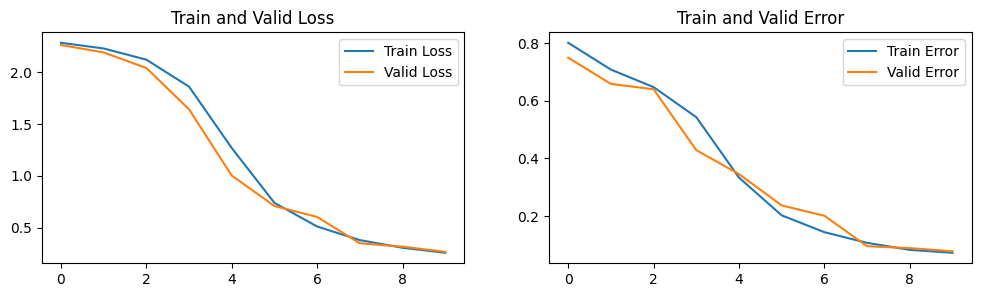

In [5]:
# cnn model for the pj
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from scipy.io import loadmat
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load data set
data = loadmat('/Users/lvangge/Desktop/Archive/project1_release/codes/digits.mat')
X = data['X']
y = data['y']
nLabels = max(y)[0]
Xvalid = data['Xvalid']
Xtest = data['Xtest']
yvalid = data['yvalid']
ytest = data['ytest']

# Standardize columns and add bias
def standardize_cols(M, mu=None, sigma2=None):
    M = M.astype(float)  # transform the matrix to float type
    nrows, ncols = M.shape

    if mu is None or sigma2 is None:
        mu = np.mean(M, axis=0)
        sigma2 = np.std(M, axis=0)
        # handle the situation that sigma == 0
        sigma2[sigma2 < np.finfo(float).eps] = 1

    S = M - mu
    if ncols > 0:
        S = S / sigma2

    return S, mu, sigma2

X, mu, sigma = standardize_cols(X)
# X = np.hstack((np.ones((X.shape[0], 1)), X)) # add bias column

Xvalid = standardize_cols(Xvalid, mu, sigma)[0]
# Xvalid = np.hstack((np.ones((Xvalid.shape[0], 1)), Xvalid))

Xtest = standardize_cols(Xtest, mu, sigma)[0]
# Xtest = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))

# Change the shape of data
X = X.reshape(-1, 1, 16, 16)
Xvalid = Xvalid.reshape(-1, 1, 16, 16)
Xtest = Xtest.reshape(-1, 1, 16, 16)

# Function to expand y to binary matrix
def linearInd2Binary(ind, nLabels):
    n = len(ind)
    y = np.zeros((n, nLabels))
    for i in range(n):
        y[i, int(ind[i])-1] = 1
    return y

# Trandform data to dataloader
y = linearInd2Binary(y,nLabels)
yvalid= linearInd2Binary(yvalid,nLabels)
ytest = linearInd2Binary(ytest,nLabels)

train_dataset = TensorDataset(torch.tensor(X,dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
valid_dataset = TensorDataset(torch.tensor(Xvalid,dtype=torch.float32), torch.tensor(yvalid, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(Xtest, dtype=torch.float32), torch.tensor(ytest,dtype=torch.float32))

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Define train achitecture
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, nLabels)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
model = Model()

# Define loss function, learning rate and optimizer
loss_func = nn.CrossEntropyLoss()
learn_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

# Training loop
def train(dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_err = 0, 0

    for X, y in dataloader:
        pred = model(X)
        loss = loss_func(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_err += (torch.argmax(F.softmax(pred, dim=1), dim=1) != torch.argmax(y, dim=1)).type(torch.float).sum().item()
        train_loss += loss.item()

    train_loss /= num_batches
    train_err /= size

    return train_loss, train_err

# Test-Valid loop
def test(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_err = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_func(pred, y)
            test_err += (torch.argmax(F.softmax(pred, dim=1), dim=1) != torch.argmax(y, dim=1)).type(torch.float).sum().item()
            test_loss += loss.item()

    test_loss /= num_batches
    test_err /= size
    
    return test_loss, test_err

# Main training and evaluating loop
if __name__ == '__main__':
    epochs = 10
    train_loss = []
    train_err = []
    valid_loss = []
    valid_err = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, epoch_train_err = train(train_dl, model, loss_func, optimizer)

        model.eval()
        epoch_valid_loss, epoch_valid_err = test(valid_dl, model, loss_func)

        train_loss.append(epoch_train_loss)
        train_err.append(epoch_train_err)
        valid_loss.append(epoch_valid_loss)
        valid_err.append(epoch_valid_err)

        template = ('Epoch:{:2d}, train_err:{:.1f}%, train_loss:{:.3f}, valid_err:{:.1f}%, valid_loss:{:.3f}')
        print(template.format(epoch + 1, epoch_train_err*100, epoch_train_loss, epoch_valid_err*100, epoch_valid_loss))

    print("Traing done")

    test_loss, test_err = test(test_dl, model, loss_func)
    print(('Test_err:{:.1f}%, test_loss:{:.3f}').format(test_err*100, test_loss))

def show_plot():
    epoch_range = range(epochs)
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_loss, label='Train Loss')
    plt.plot(epoch_range, valid_loss, label='Valid Loss')
    plt.legend()
    plt.title('Train and Valid Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, train_err, label='Train Error')
    plt.plot(epoch_range, valid_err, label='Valid Error')
    plt.legend()
    plt.title('Train and Valid Error')

    plt.show()

show_plot()